# **Variational Autoencoder (VAE) for Image Steganography Using CIFAR-10 Dataset**

We will implement a variational autoencoder (VAE) for image steganography on the CIFAR-10 dataset using Pytorch.

**Import Libraries**

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

**Define Funcion to Hide Bits**

In [74]:
def hide_bits(mu, bit_indices):
    # Flip the specified bits
    mu_flipped = mu.clone()
    for idx in bit_indices:
        mu_flipped[:, idx] = 1 - mu_flipped[:, idx]  # Flip the bit

    return mu_flipped

**Define Function to Extract Hidden Bits**

In [75]:
def extract_bits(recon_images, original_images):
    # Compute the absolute difference between reconstructed and original images
    abs_diff = torch.abs(recon_images - original_images)
    # Binarize the absolute difference to extract the hidden bits
    hidden_bits = (abs_diff > 0.5).float()
    return hidden_bits

**Define VAE Architecture**

In [76]:
latent_dim = 128  # Update latent dimension for CIFAR-10

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Define mean and variance layers
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),  # Adjusted linear layer to match encoder output size
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),  # Reshape to match expected input size of first conv transpose layer
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = z.view(z.size(0), latent_dim, 1, 1)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

**Define Loss Function**

In [77]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

**Initialize VAE Model and Optimizer**

In [78]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

**Load Dataset**

In [79]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize CIFAR-10 images to 32x32
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


**Train VAE**

In [80]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        # Ensure that recon_batch has the same size as data
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [0/50000 (0%)]	Loss: 273900.500000
Train Epoch: 0 [12800/50000 (26%)]	Loss: 247908.093750
Train Epoch: 0 [25600/50000 (51%)]	Loss: 242468.625000
Train Epoch: 0 [38400/50000 (77%)]	Loss: 243777.765625
Train Epoch: 1 [0/50000 (0%)]	Loss: 239009.484375
Train Epoch: 1 [12800/50000 (26%)]	Loss: 236247.156250
Train Epoch: 1 [25600/50000 (51%)]	Loss: 236389.171875
Train Epoch: 1 [38400/50000 (77%)]	Loss: 235232.609375
Train Epoch: 2 [0/50000 (0%)]	Loss: 237433.781250
Train Epoch: 2 [12800/50000 (26%)]	Loss: 233714.453125
Train Epoch: 2 [25600/50000 (51%)]	Loss: 234834.546875
Train Epoch: 2 [38400/50000 (77%)]	Loss: 231356.906250
Train Epoch: 3 [0/50000 (0%)]	Loss: 233725.156250
Train Epoch: 3 [12800/50000 (26%)]	Loss: 234662.140625
Train Epoch: 3 [25600/50000 (51%)]	Loss: 236151.015625
Train Epoch: 3 [38400/50000 (77%)]	Loss: 233625.687500
Train Epoch: 4 [0/50000 (0%)]	Loss: 235393.562500
Train Epoch: 4 [12800/50000 (26%)]	Loss: 226991.500000
Train Epoch: 4 [25600/50000 (51%)]	

**Plot Latent Vectors**

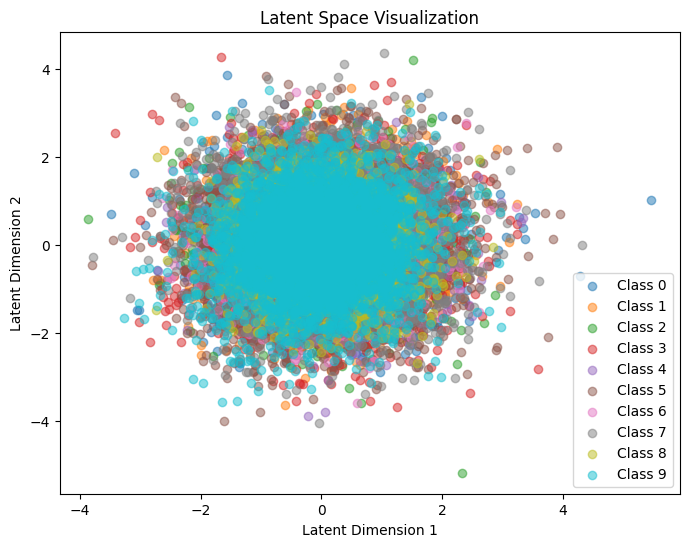

In [81]:
# Set model to evaluation mode
vae.eval()

# Lists to store latent vectors
latent_vectors = []
labels = []

# Iterate through the dataset and encode images
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(train_loader):
        mu, _ = vae.encode(data)
        latent_vectors.append(mu)
        labels.append(label)

# Concatenate latent vectors and labels
latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

# Convert tensors to numpy arrays
latent_vectors = latent_vectors.numpy()
labels = labels.numpy()

# Plot the latent vectors
plt.figure(figsize=(8, 6))
for i in range(10):  # Assuming 10 classes in CIFAR-10
    indices = labels == i
    plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], label=f'Class {i}', alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()

**Plot Original and Reconstructed Images**

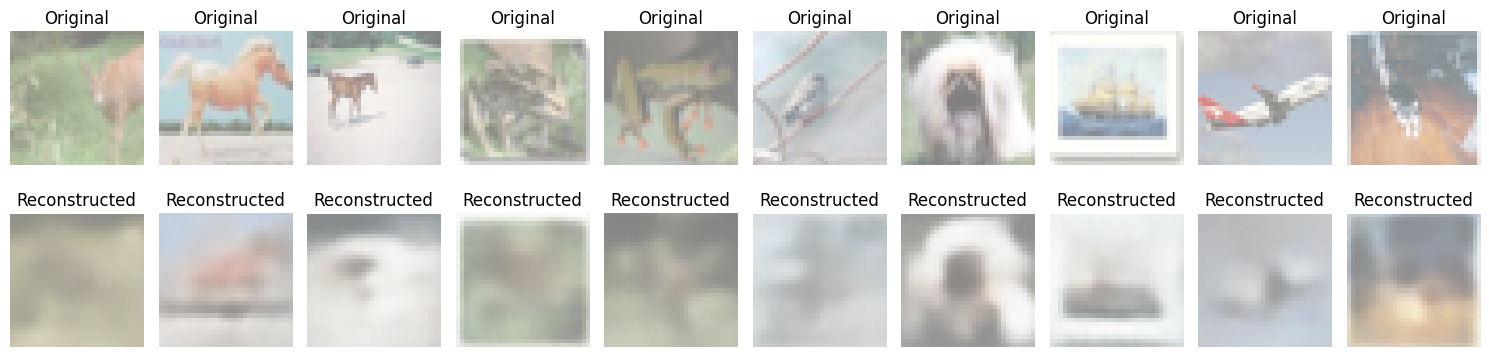

In [82]:
# Function to convert tensor to NumPy array and reshape to image
def to_img(x):
    x = 0.5 * (x + 1)  # Denormalize
    x = x.clamp(0, 1)  # Ensure values are in [0, 1]
    x = x.view(x.size(0), 3, 32, 32)  # Reshape to image format
    return x

# Get a batch of data from the train_loader
for images, _ in train_loader:
    break

# Get reconstructed images from the VAE
recon_images, _, _ = vae(images)

# Convert tensors to NumPy arrays and reshape to images
images = to_img(images).detach().numpy()
recon_images = to_img(recon_images).detach().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))

for i in range(10):
    axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)), interpolation='nearest')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(np.transpose(recon_images[i], (1, 2, 0)), interpolation='nearest')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()

**Hide Bits in Latent Space and Reconstruct Images with Hidden Bits**

In [83]:
# Hide bits in the latent space
bit_indices_to_hide = [2, 5, 10]  # Example indices of bits to hide
hidden_mu = hide_bits(mu, bit_indices_to_hide)

# Reshape hidden_mu to match the expected input shape of the linear layer
hidden_mu_reshaped = hidden_mu.view(-1, latent_dim)

# Reconstruct images from the modified latent variables
reconstructed_images = vae.decoder(vae.reparameterize(hidden_mu_reshaped, logvar))

# Convert tensors to NumPy arrays and reshape to images
recon_images_with_hidden_bits = to_img(reconstructed_images).detach().numpy()

**Plot Original and Reconstructed Images with Hidden Bits**

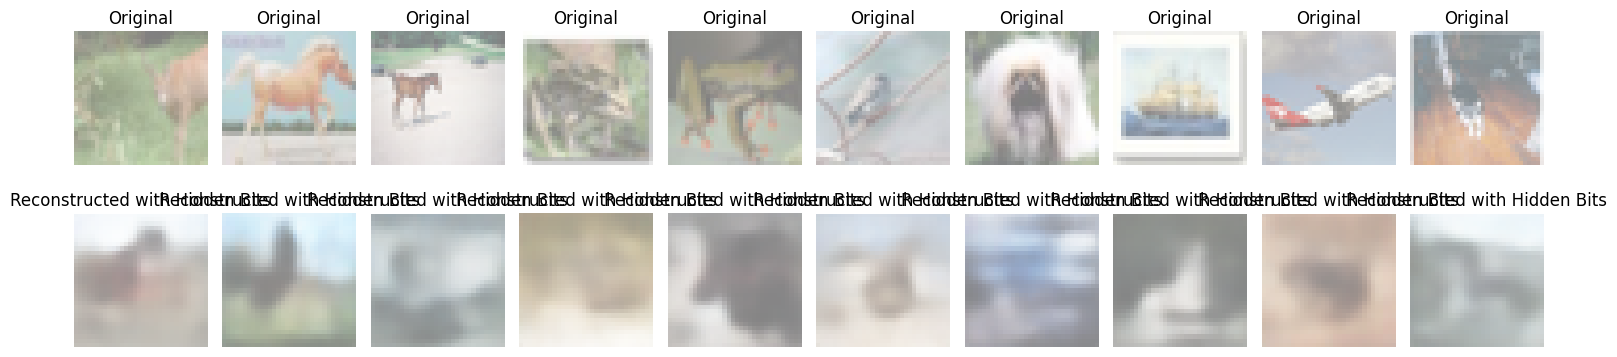

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))

for i in range(10):
    axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose dimensions for displaying RGB images
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(np.transpose(recon_images_with_hidden_bits[i], (1, 2, 0)))  # Transpose dimensions for displaying RGB images
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed with Hidden Bits')

plt.tight_layout()
plt.show()

**Extract Hidden Bits From Reconstructed Images**

In [85]:
extracted_bits = extract_bits(reconstructed_images, data)
print("Extracted hidden bits:")
for i in range(len(extracted_bits)):
    hidden_bits = extracted_bits[i, :, :, :]
    print("Image {}: {}".format(i, hidden_bits[:, bit_indices_to_hide]))

Extracted hidden bits:
Image 0: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

**Plot Modified Latent Vectors**

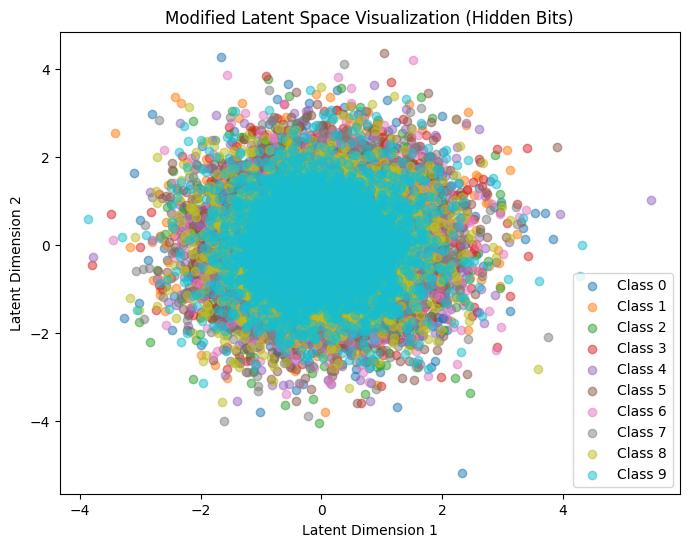

In [86]:
# Set model to evaluation mode
vae.eval()

# Lists to store latent vectors
hidden_latent_vectors = []

# Iterate through the dataset and encode images
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        mu, _ = vae.encode(data)
        hidden_mu = hide_bits(mu, bit_indices_to_hide)  # Hide specific bits
        hidden_latent_vectors.append(hidden_mu)

# Concatenate latent vectors
hidden_latent_vectors = torch.cat(hidden_latent_vectors, dim=0)

# Convert tensors to numpy arrays
hidden_latent_vectors = hidden_latent_vectors.numpy()

# Plot the modified latent vectors
plt.figure(figsize=(8, 6))
for i in range(10):  # Assuming 10 classes in CIFAR-10
    indices = labels == i
    plt.scatter(hidden_latent_vectors[indices, 0], hidden_latent_vectors[indices, 1], label=f'Class {i}', alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Modified Latent Space Visualization (Hidden Bits)')
plt.legend()
plt.show()